In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import norm, lognorm, ncx2

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir))

from model.kalman_heston_filter import kalman_like_heston_filter
from model.heston_mod import heston_DGP
from model.Heston import *

In [ ]:
df = pd.read_parquet("/Users/hyunminhong/Kalman-Heston-Filter/data/oxford_data.parquet")

df = df.rename(columns={'Unnamed: 0': 'Time'})
df = df.loc[df['Symbol']=='.SPX'].reset_index(drop=True)
df['Time'] = pd.to_datetime(df['Time'], utc=True) 
df['Time'] = df['Time'].dt.date
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)

In [6]:
df = df.loc[pd.to_datetime('2006-01-01'):pd.to_datetime('2010-06-01')]

# Distribution of RV

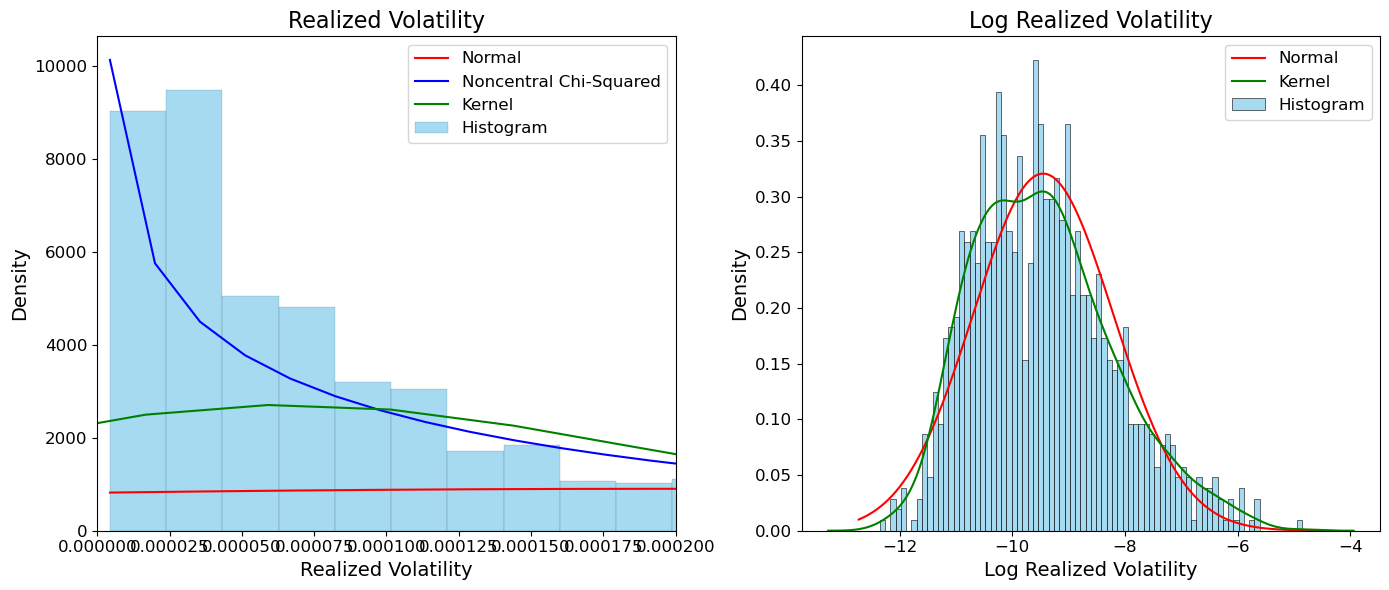

In [7]:
# Prepare data
rv = df['rv10'].dropna()
log_rv = np.log(rv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Realized volatility histogram and density curves
sns.histplot(rv, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rv.min(), rv.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the log normal distribution
# shape_logn, loc_logn, scale_logn = lognorm.fit(rv, floc=0)  # Usually loc is set to 0
# ax[0].plot(x_vals, lognorm.pdf(x_vals, shape_logn, loc=loc_logn, scale=scale_logn), 'r', label='Lognormal')

mu, std = norm.fit(rv)
ax[0].plot(x_vals, norm.pdf(x_vals, mu, std), 'r', label='Normal')

# Fit the noncentral chi-squared distribution with loc fixed at 0
df_ncx2, nc_val, loc_val, scale_val = ncx2.fit(rv, floc=0)
ax[0].plot(x_vals, ncx2.pdf(x_vals, df_ncx2, nc_val, loc=loc_val, scale=scale_val), 'b', label='Noncentral Chi-Squared')

# Add kernel density estimate
sns.kdeplot(rv, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Realized Volatility', fontsize=16)
ax[0].set_xlabel('Realized Volatility', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].set_xlim(0, 0.0002)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log realized volatility histogram and normal density
sns.histplot(log_rv, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rv)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rv, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log Realized Volatility', fontsize=16)
ax[1].set_xlabel('Log Realized Volatility', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


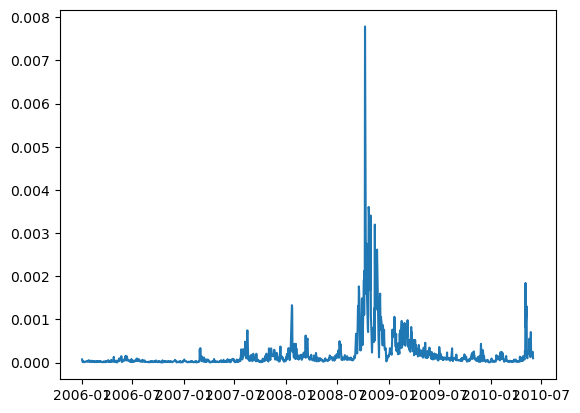

In [8]:
plt.plot(rv)

In [18]:
np.log(df['close_price']).diff()

Time
2014-01-02         NaN
2014-01-03   -0.000344
2014-01-06   -0.002646
2014-01-07    0.006113
2014-01-08   -0.000278
                ...   
2018-05-24   -0.002390
2018-05-28   -0.011562
2018-05-29    0.012634
2018-05-30   -0.006922
2018-05-31    0.010677
Name: close_price, Length: 1112, dtype: float64

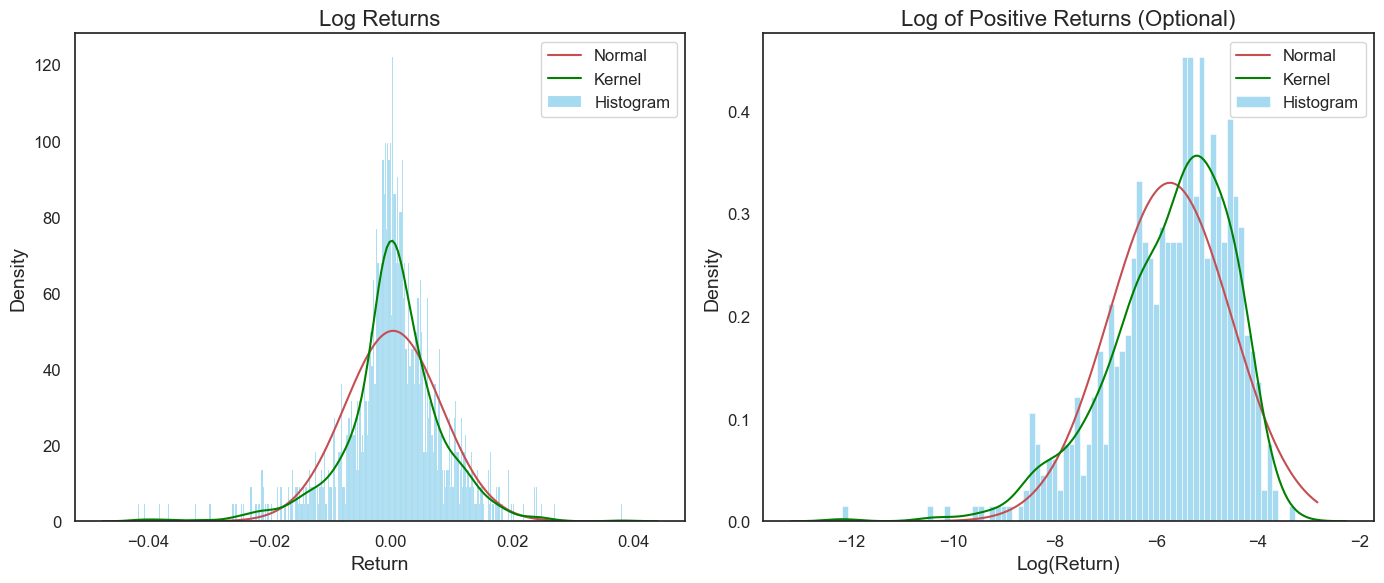

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Prepare data
rtn = np.log(df['close_price']).diff().dropna()
log_rtn = np.log(rtn[rtn > 0])  # optional, if you want to still look at log of positive returns

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Left subplot: Return histogram and density curves
sns.histplot(rtn, kde=False, stat='density', bins=400, color='skyblue', ax=ax[0], label='Histogram')

xmin, xmax = rtn.min(), rtn.max()
x_vals = np.linspace(xmin, xmax, 500)

# Fit and plot the normal distribution
mu_rtn, std_rtn = norm.fit(rtn)
ax[0].plot(x_vals, norm.pdf(x_vals, mu_rtn, std_rtn), 'r', label='Normal')

# Add kernel density estimate
sns.kdeplot(rtn, ax=ax[0], color='green', label='Kernel')

ax[0].set_title('Log Returns', fontsize=16)
ax[0].set_xlabel('Return', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# Right subplot: Log of positive returns (optional, for exploration)
sns.histplot(log_rtn, kde=False, stat='density', bins=80, color='skyblue', ax=ax[1], label='Histogram')
xmin_log, xmax_log = ax[1].get_xlim()
x_vals_log = np.linspace(xmin_log, xmax_log, 500)
mu_log, std_log = norm.fit(log_rtn)
ax[1].plot(x_vals_log, norm.pdf(x_vals_log, mu_log, std_log), 'r', label='Normal')
sns.kdeplot(log_rtn, ax=ax[1], color='green', label='Kernel')

ax[1].set_title('Log of Positive Returns (Optional)', fontsize=16)
ax[1].set_xlabel('Log(Return)', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


# Autocorrelation

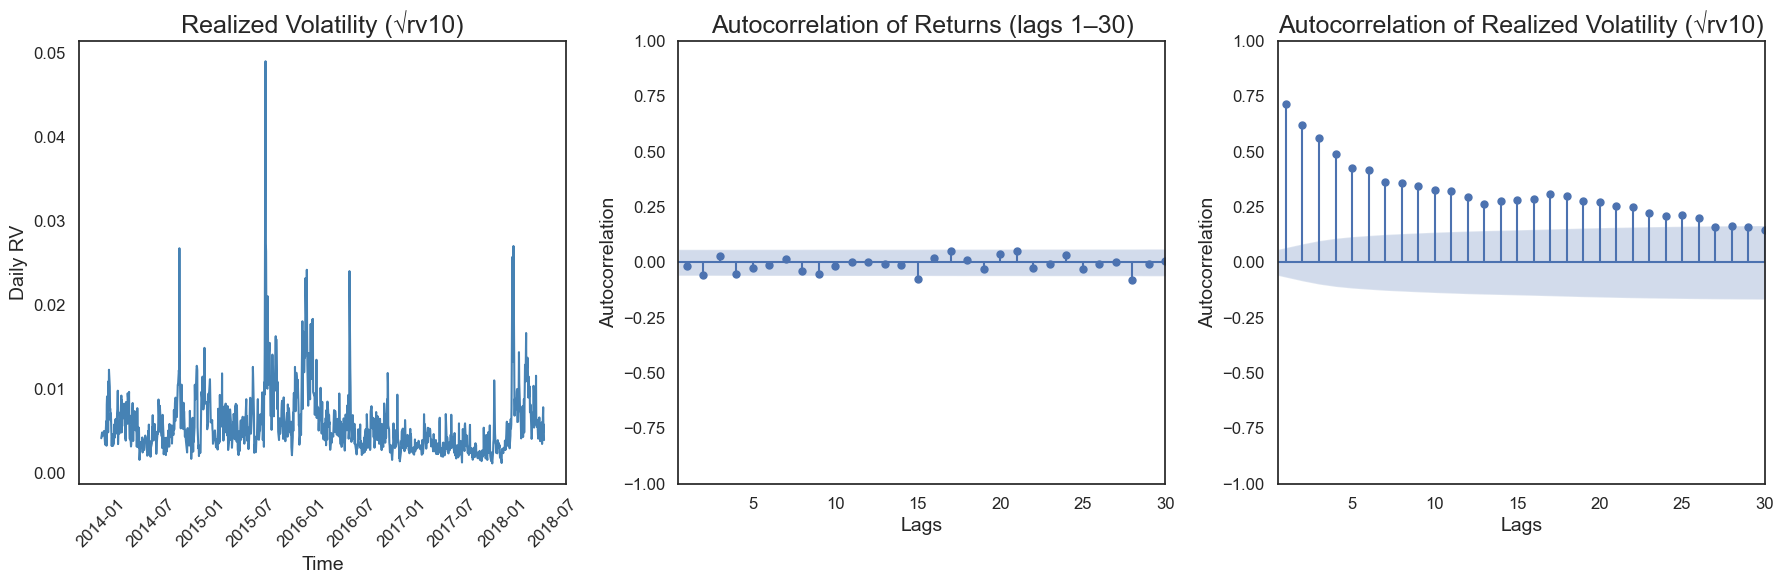

In [6]:
returns = np.log(df['close_price']).diff().iloc[1:]
rv10 = df['rv10'].iloc[1:]
realized_vol = np.sqrt(rv10)

sns.set(style='white')

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volatility plot 
sns.lineplot(x=realized_vol.index, y=realized_vol.values, ax=axes[0], color='steelblue')
axes[0].set_title('Realized Volatility (√rv10)', fontsize=18)
axes[0].set_xlabel('Time', fontsize=14)
axes[0].set_ylabel('Daily RV', fontsize=14)
axes[0].tick_params(axis='both', labelsize=12)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# 2. Autocorrelation of returns
plot_acf(returns, lags=30, ax=axes[1])
axes[1].set_title('Autocorrelation of Returns (lags 1–30)', fontsize=18)
axes[1].set_xlabel('Lags', fontsize=14)
axes[1].set_ylabel('Autocorrelation', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_xlim(0.5, 30)

# 3. Autocorrelation of realized volatility
plot_acf(realized_vol, lags=30, ax=axes[2])
axes[2].set_title('Autocorrelation of Realized Volatility (√rv10)', fontsize=18)
axes[2].set_xlabel('Lags', fontsize=14)
axes[2].set_ylabel('Autocorrelation', fontsize=14)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].set_xlim(0.5, 30)

plt.tight_layout()
plt.show()